In [87]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

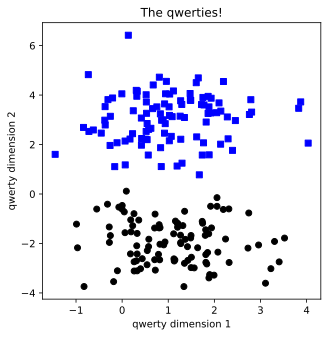

In [88]:
# create data

nPerClust = 100
blur = 1

A = [  1,  3 ]
B = [  1, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [89]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

# Functions to build and train the model

In [90]:
# create a class for the model WITH BATCH NORM

class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(2,16)

    ### hidden layers
    self.fc1    = nn.Linear(16,32)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
    self.fc2    = nn.Linear(32,20)
    self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer

    ### output layer
    self.output = nn.Linear(20,1)

  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )


    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)    # weighted combination
      x = F.relu(x)      # activation function


    else:
      # hidden layer 1
      x = F.relu( self.fc1(x) )

      # hidden layer 2
      x = F.relu( self.fc2(x) )

    # output layer
    return self.output(x)

In [91]:
# a function that trains the model

# global parameter
numepochs = 200

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

# Test

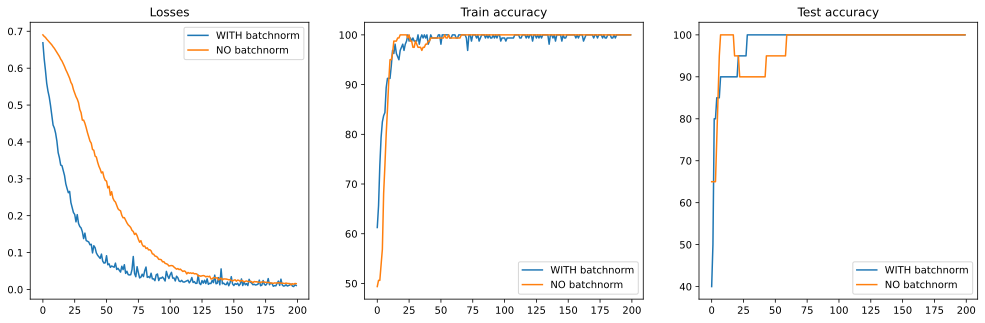

In [92]:
# takes ~2 mins

# create and train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)



# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()